<a href="https://colab.research.google.com/github/samitha278/multilayer-perceptron-char-lm/blob/main/mlp_batch_norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

In [23]:
from google.colab import files

uploaded = files.upload()

Saving names.txt to names.txt


In [24]:
words = open('names.txt','r').read().splitlines()

## Character mapping

In [25]:
stoi = {s:i+1 for i,s in enumerate(sorted(set(''.join(words))))}
stoi['.'] = 0
itos = {i:s for i,s in stoi.items()}

itos

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

## Dataset split : Train , Dev , Test

In [26]:
def build_dataset(data,n=3):

  x , y = [],[]


  for d in data:

    context = [0]*n

    for ch in d:

      ix = stoi[ch]
      x.append(context)
      y.append(ix)

      ix = context[1:] + [ix]


  x = torch.tensor(x)
  y = torch.tensor(y)

  return x,y


### Train/dev/test - 80/10/10 %

In [27]:
n = len(words)
n1 = int(0.8*n)
n2 = int(0.9*n)


random.shuffle(words)

print(words[:5])

xtr , ytr = build_dataset(words[:n1])
xdev , ydev = build_dataset(words[n1:n2])
xtest , ytest = build_dataset(words[n2:])

['leighla', 'dymond', 'amarachi', 'bretton', 'kaceson']


## Parameters Initialization without proper initializataion

In [28]:
char_l = len(stoi.keys())
context_w = 3
vec_size = 10
h_size = 200

In [29]:
g = torch.Generator().manual_seed(21746)

C = torch.randn((char_l,vec_size),              generator=g ,requires_grad=True)
W1 = torch.randn((context_w * vec_size,h_size), generator=g ,requires_grad=True)
b1 = torch.randn(h_size,                        generator=g ,requires_grad=True)
W2 = torch.randn((h_size,char_l),               generator=g ,requires_grad=True)
b2 = torch.randn(char_l,                        generator=g ,requires_grad=True)

params = [C,W1,b1,W2,b2]

## Full pass

In [30]:
max_iter = 10000
losses = []

lr = 0.01

In [31]:
for i in range(max_iter):


  #minibatch
  ix = torch.randint(0,xtr.shape[0],(32,))


  #forward pass

  #embedding
  emb = C[xtr[ix]]
  emb_cor =  emb.view(-1,vec_size*context_w)

  #hidden layer
  h_preact = emb_cor @ W1 + b1
  h = torch.tanh(h_preact)

  #output layer
  logits = h @ W2 +b2

  loss = F.cross_entropy(logits,ytr[ix])


  #backward pass
  for p in params:
    p.grad = None

  loss.backward()


  #update
  for p in params:
    p.data -= lr * p.grad

  if i%1000==0:
    print(f'{i}/{max_iter}  : {loss}')

  losses.append(loss.item())


  #break



0/10000  : 25.69584083557129
1000/10000  : 2.8118255138397217
2000/10000  : 2.933884859085083
3000/10000  : 3.040231704711914
4000/10000  : 2.9004342555999756
5000/10000  : 2.9629065990448
6000/10000  : 2.820451498031616
7000/10000  : 2.505594491958618
8000/10000  : 3.0851244926452637
9000/10000  : 3.0358357429504395


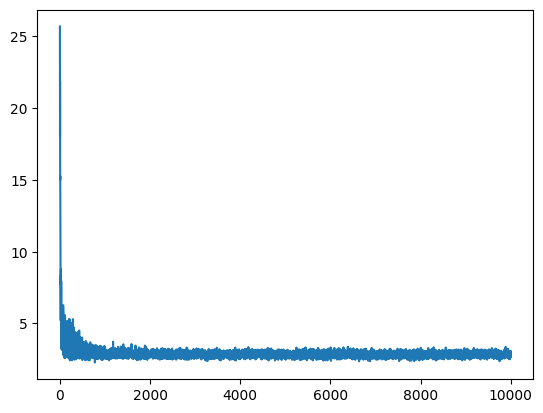

In [32]:
plt.plot(losses)
plt.show()

### Why does the loss curve look like a hockey stick?  

- At the beginning of training, if the model is **not properly initialized**, the initial loss can be **very high**.  
- As training progresses, the optimizer quickly reduces this large error, causing a **sharp drop** in the loss.  
- After this rapid decrease, the loss decreases more slowly and flattens out, forming the **"hockey stick" shape**.  


## Saturated tanh problem

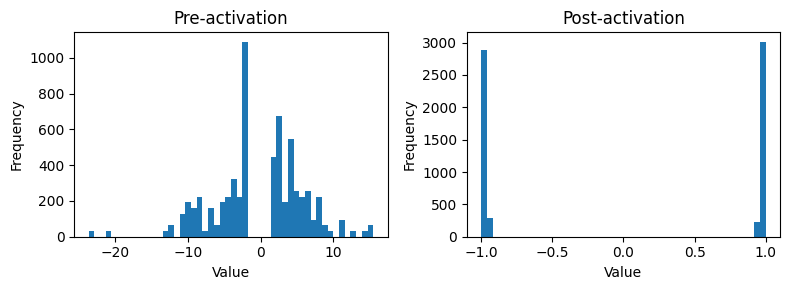

In [33]:
plt.figure(figsize=(8,3))

# Pre-activation
plt.subplot(1, 2, 1)
plt.hist(h_preact.view(-1).tolist(), bins=50)
plt.title("Pre-activation")
plt.xlabel("Value")
plt.ylabel("Frequency")

# Post-activation
plt.subplot(1, 2, 2)
plt.hist(h.view(-1).tolist(), bins=50)
plt.title("Post-activation")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

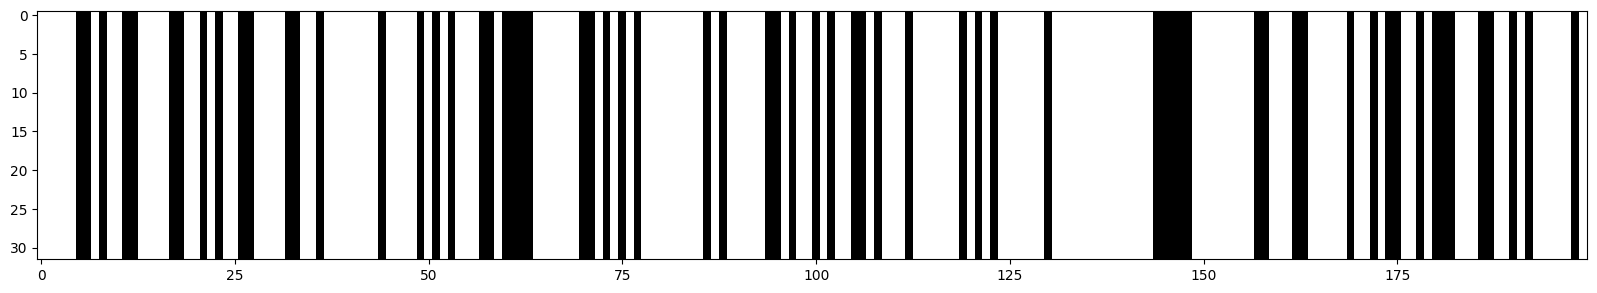

In [34]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99 , cmap = 'gray' , interpolation= 'nearest')
#entire column of whites means dead neuron

## Fixing initial loss and saturated tanh

In [35]:
char_l = len(stoi.keys())
context_w = 3
vec_size = 10
h_size = 200
g = torch.Generator().manual_seed(21746)

C = torch.randn((char_l,vec_size),              generator=g )
W1 = torch.randn((context_w * vec_size,h_size), generator=g )  * 0.1
b1 = torch.randn(h_size,                        generator=g )  * 0.01
W2 = torch.randn((h_size,char_l),               generator=g )  * 0.01
b2 = torch.randn(char_l,                        generator=g )  * 0


params = [C,W1,b1,W2,b2]

for p in params:
  p.requires_grad= True

In [36]:

max_iter = 10000
losses = []
lr = 0.01

In [37]:
for i in range(max_iter):


  #minibatch
  ix = torch.randint(0,xtr.shape[0],(32,))


  #forward pass

  #embedding
  emb = C[xtr[ix]]
  emb_cor =  emb.view(-1,vec_size*context_w)

  #hidden layer
  h_preact = emb_cor @ W1 + b1
  h = torch.tanh(h_preact)

  #output layer
  logits = h @ W2 +b2

  loss = F.cross_entropy(logits,ytr[ix])


  #backward pass
  for p in params:
    p.grad = None

  loss.backward()


  #update
  for p in params:
    #print(p.data,p.grad)
    p.data -= lr * p.grad

  if i%1000==0:
    print(f'{i}/{max_iter}  : {loss}')

  losses.append(loss.item())


  #break

0/10000  : 3.315943956375122
1000/10000  : 2.662580966949463
2000/10000  : 2.742511510848999
3000/10000  : 2.680687189102173
4000/10000  : 2.653306722640991
5000/10000  : 2.714205741882324
6000/10000  : 2.949309825897217
7000/10000  : 2.7903823852539062
8000/10000  : 2.688241481781006
9000/10000  : 2.7098052501678467


#### fixed initial loss

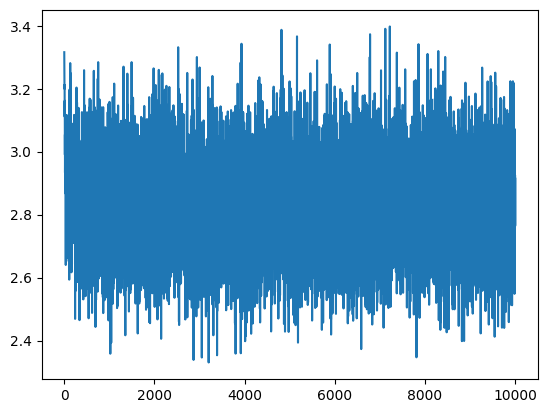

In [38]:
plt.plot(losses)
plt.show()

### fixed saturated tanh

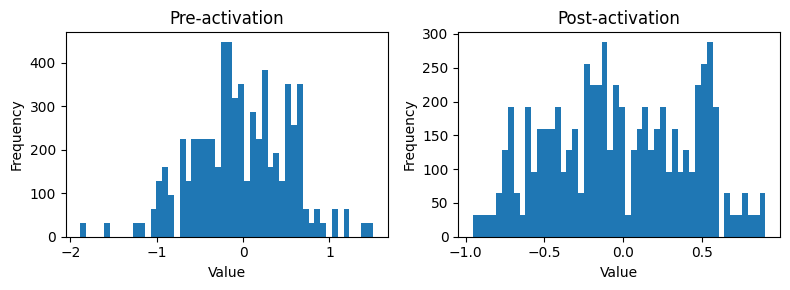

In [39]:
plt.figure(figsize=(8,3))

# Pre-activation
plt.subplot(1, 2, 1)
plt.hist(h_preact.view(-1).tolist(), bins=50)
plt.title("Pre-activation")
plt.xlabel("Value")
plt.ylabel("Frequency")

# Post-activation
plt.subplot(1, 2, 2)
plt.hist(h.view(-1).tolist(), bins=50)
plt.title("Post-activation")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

### Initaial scale : kaiming init

In [40]:
torch.randn(1000).std()

tensor(0.9841)

In [41]:
(torch.randn(1000) * 0.2 ).std()

tensor(0.1927)

tensor(-0.0042) tensor(1.0022)
tensor(-0.0006) tensor(1.0049)


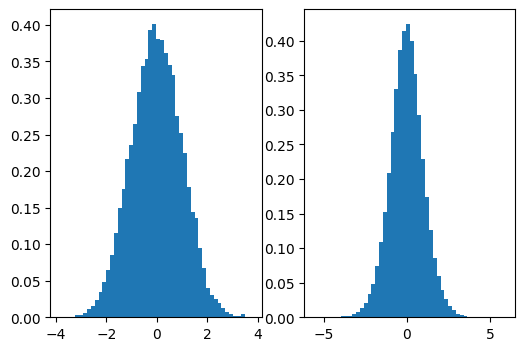

In [42]:
x = torch.randn((1000,10))
w = torch.randn((10,200))    / (10**0.5) #root of fan in

y = x @ w

print(x.mean(),x.std())
print(y.mean(),y.std())

plt.figure(figsize= (6,4))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50 , density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50 , density=True)
plt.show()

#### Kaiminig init for tanh

In [51]:
(5/3) / ((context_w * vec_size) **0.5)   #W1 multiply by this factor


0.3042903097250923

# Batch Noramalization

In [76]:
char_l = len(stoi.keys())
context_w = 3
vec_size = 10
h_size = 200
g = torch.Generator().manual_seed(2147483647)



C =  torch.randn((char_l,vec_size),              generator=g )
W1 = torch.randn((context_w * vec_size,h_size),  generator=g )  * (5/3) / ((context_w * vec_size) **0.5)   #kaminig init
#b1 = torch.randn(h_size,                         generator=g )  * 0.01
W2 = torch.randn((h_size,char_l),                generator=g )  * 0.01
b2 = torch.randn(char_l,                         generator=g )  * 0



bngain = torch.ones((1,h_size))
bnbias = torch.zeros((1,h_size))


bnmean_running = torch.zeros((1, h_size))
bnstd_running = torch.ones((1, h_size))





params = [C,W1,W2,b2,bngain,bnbias]

for p in params:
  p.requires_grad= True

In [77]:
max_iter = 50000
losses = []
lr = 0.00001
batch_size = 32



for i in range(max_iter):


  #minibatch
  ix = torch.randint(0,xtr.shape[0],(batch_size,),generator=g)


  #forward pass

  #embedding
  emb = C[xtr[ix]]
  emb_cor =  emb.view(-1,vec_size*context_w)

  #hidden layer
  h_preact = emb_cor @ W1 #+ b1    #bias not doing anything because of bn layer


  #Batch Normalization layer
  #h_preact = ((h_preact - h_preact.mean(0,keepdim=True)) / (h_preact.std(0,keepdim=True)+0.00001))

  bnmeani = h_preact.mean(0,keepdim=True)
  bnstdi = h_preact.std(0,keepdim=True)

  h_preact = bngain * (h_preact-bnmeani/(bnstdi+0.00001) ) + bnbias

  with torch.no_grad():
    bnmean_running = 0.99 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.99 * bnstd_running + 0.001 * bnstdi





  h = torch.tanh(h_preact)

  #output layer
  logits = h @ W2 +b2

  loss = F.cross_entropy(logits,ytr[ix])


  #backward pass
  for p in params:
    p.grad = None

  loss.backward()


  #update
  for p in params:
    p.data -= lr * p.grad

  if i%1000==0:
    print(f'{i}/{max_iter}  : {loss}')

  losses.append(loss.item())


0/50000  : 3.2901535034179688
1000/50000  : 3.212301254272461
2000/50000  : 3.127258777618408
3000/50000  : 3.1156563758850098
4000/50000  : 3.151245594024658
5000/50000  : 3.0815436840057373
6000/50000  : 3.1085801124572754
7000/50000  : 3.071129322052002
8000/50000  : 2.9320971965789795
9000/50000  : 2.969172716140747
10000/50000  : 2.860285520553589
11000/50000  : 2.685011386871338
12000/50000  : 3.1145572662353516
13000/50000  : 2.99249529838562
14000/50000  : 2.845067262649536
15000/50000  : 2.8326334953308105
16000/50000  : 2.9556195735931396
17000/50000  : 2.836273193359375
18000/50000  : 2.7348437309265137
19000/50000  : 2.880743980407715
20000/50000  : 3.0754127502441406
21000/50000  : 2.965859889984131
22000/50000  : 2.7926244735717773
23000/50000  : 3.0089621543884277
24000/50000  : 2.8661184310913086
25000/50000  : 2.8779263496398926
26000/50000  : 2.7765188217163086
27000/50000  : 3.0075571537017822
28000/50000  : 3.0749669075012207
29000/50000  : 2.8829169273376465
30000/

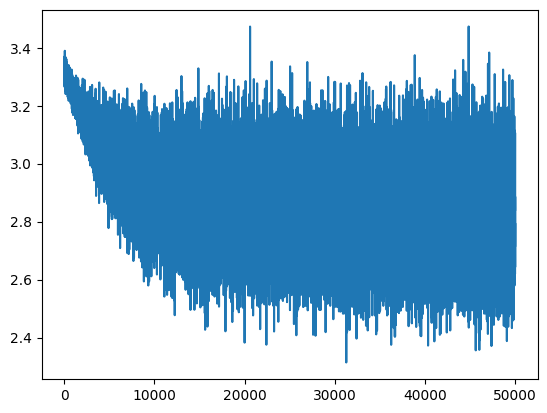

In [78]:
plt.plot(losses)
plt.show()

In [79]:
#full forward pass for training set

with torch.no_grad():
    emb = C[xtr]
    emb_cor = emb.view(-1, vec_size * context_w)
    h_preact = emb_cor @ W1 + b1

    #h_norm = (h_preact - h_preact.mean(0, keepdim=True)) / (h_preact.std(0, keepdim=True) + 1e-5)

    h_norm = (h_preact - bnmean_running) / (bnstd_running + 1e-5)
    h_norm = bngain * h_norm + bnbias

    h = torch.tanh(h_norm)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,ytr)
    print(loss)

tensor(4.5168)
